# Parameter Estimation in a Dynamic Model Describing Microalgae Growth and Lipid Biosynthesis

Consider the following model by [del Rio-Chanona _et al_ (2018)](https://doi.org/10.1002/bit.26483) describing the growth and lipid biosynthesis in _N. oceanica_, a microalga with a naturally high cellular oil content, in bubble column photobioreactor:
$$\begin{align}
\dot{X}(t) =\ & \left[\bar{\mu}(I_0(t),X(t))\left(1-\frac{k_q}{q(t)}\right) - k_d \right] X(t)\\
\dot{N}(t) =\ & - \rho_m \frac{N(t)}{k_N+N(t)} X(t)\\
\dot{q}(t) =\ & \rho_m \frac{N(t)}{k_N+N(t)} - \bar{\mu}(I_0(t),X(t))\left(1-\frac{k_q}{q(t)}\right) q(t)\\
\dot{f}(t) =\ & - \gamma_N \rho_m \frac{N(t)}{k_N+N(t)} + \bar{\mu}(I_0(t),X(t))\left(1-\frac{k_q}{q(t)}\right) \left(\gamma_q q(t)- \gamma_f f(t)\right)\\
\text{with:}\ \ \bar{\mu}(I_0,X) \coloneqq\ & \frac{1}{H} \int_{0}^{H} \mu(I_0,X,z) dz\\ \approx\ & \frac{1}{2K} \left[ \mu(I_0,X,0) + 2 \sum_{k=1}^{K-1} \mu(I_0,X,{\textstyle\frac{k}{K}H}) + \mu(I_0,X,H) \right]\\
                \mu(I_0,X,z) \coloneqq\ & \mu_m \frac{I(I_0,X,z)}{k_I+I(I_0,X,z)+I(I_0,X,z)^2/k'_I}\\
                I(I_0,X,z) \coloneqq\ & I_0 \exp\left(-(\epsilon_0+\epsilon_X X)z\right)
\end{align}$$
where $N$ (mg L$^{-1}$) is the culture nitrate concentration; $X$ (g L$^{-1}$), the biomass concentration; $q$ (mg g$^{-1}$), the nitrogen quota; and $f$ [mg g$^{-1}$], the FAME quota.

The bubble column is illuminated on one side only and assimilated to a column with square cross-section of width $H=4.4$ cm. Guesses and ranges for the model parameters are reported in the table below.

Parameter | Guess | Units | Range |   | Parameter | Guess | Units | Range
:-------- | ----: | :---- | :---- | - | :-------- | ----: | :---- | :----
$\mu_m$      | $0.36$  | $\rm h^{-1}$                  | $[0.3,1]$  || $\gamma_q$   | $6.69$   | $\rm g\,mg^{-1}$ |  $[4,15]$
$k_d$        | $0.00$  | $\rm h^{-1}$                  | $[0,0.5]$  || $\gamma_N$   | $7.53$   | $\rm L\,mg^{-1}$ |  $[1,10]$
$k_q$        | $19.6$  | $\rm mg\,g^{-1}$              | $[10,100]$ || $\gamma_f$   | $0.001$  | $\rm g\,mg^{-1}$ |  $[0.0002,0.004]$
$\rho_m$     | $2.69$  | $\rm mg\,g^{-1}\,h^{-1}$      | $[1,10]$   || $\tau_q$     | $0.138$  | $\rm g\,mg^{-1}$ |  $[0.05,0.2]$
$k_N$        | $0.80$  | $\rm mg\,L^{-1}$              | $[0.2,2]$  || $\delta$     | $9.90$   | $-$              |  $[5,20]$
$k_I$        | $91.2$  | $\rm \mu mol\,m^{-2}\,s^{-1}$ | $[50,200]$ || $Y_0$        | $-0.456$ | $-$              |  $[-2,2]$
$k'_I$       | $100.0$ | $\rm \mu mol\,m^{-2}\,s^{-1}$ | $[80,250]$ || $\epsilon_0$ | $0.00$   | $\rm m^{-1}$ |  $[0,50]$
$\epsilon_X$ | $196.4$ | $\rm L\,kg^{-1}\,m^{-1}$      | $[50,300]$ | $\qquad\qquad$ 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc
import cronos
import canon
from magnus import ParEst

We start by defining the DAG for the dynamic model:

In [2]:
IVPDAG = pymc.FFGraph()

# States
X  = pymc.FFVar(IVPDAG, "X") # biomass concentration [mg/L]
N  = pymc.FFVar(IVPDAG, "N") # nitrate concentration [mg/L]
q  = pymc.FFVar(IVPDAG, "q") # internal nitrogen quota [mg/g]
f  = pymc.FFVar(IVPDAG, "f") # internal FAME quota [mg/g]

# Controls
I0 = pymc.FFVar(IVPDAG, "I0") # incident light intensity [µmol/m2/s]

# Initial concentrations
X0 = pymc.FFVar(IVPDAG, "X0")
N0 = pymc.FFVar(IVPDAG, "N0")
q0 = pymc.FFVar(IVPDAG, "q0")
f0 = pymc.FFVar(IVPDAG, "f0")

# Parameters
mum  = pymc.FFVar(IVPDAG, "mum")   # maximal growth rate [/h]
kd   = pymc.FFVar(IVPDAG, "kd")    # decay rate [/h]
rhom = pymc.FFVar(IVPDAG, "rhom")  #  maximal nitrate internalisation rate [mg/g/h]
kq   = pymc.FFVar(IVPDAG, "kq")    # minimal internal nitrogen quota [mg/g]
kN   = pymc.FFVar(IVPDAG, "kN")    # nitrate half-saturation constant [mg/L]
kI1  = pymc.FFVar(IVPDAG, "kI1")   # light half-saturation constant [µmol/m2/s]
kI2  = pymc.FFVar(IVPDAG, "kI2")   # light inhibition constant [µmol/m2/s]
gq   = pymc.FFVar(IVPDAG, "gq")    # yield of nitrate internalisation for FAME synthesis [g/mg]
gN   = pymc.FFVar(IVPDAG, "gN")    # yield of internal nitrogen quota for FAME synthesis [L/mg]
gf   = pymc.FFVar(IVPDAG, "gf")    # yield of internal FAME quota for FAME synthesis [g/mg]
e0   = pymc.FFVar(IVPDAG, "e0")    # basal light attenuation rate [/m]
eX   = pymc.FFVar(IVPDAG, "eX")    # biomass-dependent light attenuation rate [m2/kg = 1e6 L/g/m]
Y0   = pymc.FFVar(IVPDAG, "Y0")    # basal chlorophyll fluorescence Y(II) level [-]
d    = pymc.FFVar(IVPDAG, "dq")    # nitrogen-dependent chlorophyll fluorescence Y(II) reference [-]
tq   = pymc.FFVar(IVPDAG, "tq")    # nitrogen-dependent chlorophyll fluorescence Y(II) rate [g/mg]

# Constants
H = 0.044 # light depth [m]

We instantiate `ODESLV` and populate it with the dynamic model expressions:

In [3]:
IVP = cronos.ODESLV()

IVP.set_dag( IVPDAG )
IVP.set_parameter( [mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, d, tq] )
IVP.set_constant( [I0, X0, N0, q0, f0] )
IVP.set_state( [X, N, q, f] )

timegrid = np.linspace( 0, 252, 22 ).tolist()
print( timegrid )
IVP.set_time( timegrid ) # measurement times every 12 h

K = 20
for k in range(K+1):
    z   = k / K * H
    Iz  = I0 * pymc.exp( -z * ( e0 + eX * X ) )
    muz = mum * Iz / ( kI1 + Iz + Iz**2 / kI2 )

    if k == 0:
        mu = muz
    elif k == K:
        mu += muz
    else:
        mu += 2 * muz
mu /= 2*K
#mu = mum * I0 / ( kI1 + I0 + I0**2 / kI2 )
#print( mu.str() )

rho = rhom * N / ( kN + N )

dX  = ( mu * ( 1 - kq / q ) - kd ) * X
dN  = - rho * X
dq  = rho - mu * ( 1 - kq / q ) * q
df  = - gN * rho + mu * ( 1 - kq / q ) * ( gq * q - gf * f )
YII = Y0 + pymc.exp( tq * q ) / ( pymc.exp( tq * q ) + d )

IVP.set_differential( [dX, dN, dq, df] )
IVP.set_initial( [ X0, N0, q0, f0] )

Y = [ X, N, q, f, YII ]
F = []
for k in range(len(timegrid)):
  F.append( { k*len(Y)+i: Y[i] for i in range(len(Y)) } )
IVP.set_function( F )
print( IVP.eqn_function )

IVP.setup()

[0.0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0, 84.0, 96.0, 108.0, 120.0, 132.0, 144.0, 156.0, 168.0, 180.0, 192.0, 204.0, 216.0, 228.0, 240.0, 252.0]
[{0: X, 1: N, 2: q, 3: f, 4: Z275}, {5: X, 6: N, 7: q, 8: f, 9: Z275}, {10: X, 11: N, 12: q, 13: f, 14: Z275}, {15: X, 16: N, 17: q, 18: f, 19: Z275}, {20: X, 21: N, 22: q, 23: f, 24: Z275}, {25: X, 26: N, 27: q, 28: f, 29: Z275}, {30: X, 31: N, 32: q, 33: f, 34: Z275}, {35: X, 36: N, 37: q, 38: f, 39: Z275}, {40: X, 41: N, 42: q, 43: f, 44: Z275}, {45: X, 46: N, 47: q, 48: f, 49: Z275}, {50: X, 51: N, 52: q, 53: f, 54: Z275}, {55: X, 56: N, 57: q, 58: f, 59: Z275}, {60: X, 61: N, 62: q, 63: f, 64: Z275}, {65: X, 66: N, 67: q, 68: f, 69: Z275}, {70: X, 71: N, 72: q, 73: f, 74: Z275}, {75: X, 76: N, 77: q, 78: f, 79: Z275}, {80: X, 81: N, 82: q, 83: f, 84: Z275}, {85: X, 86: N, 87: q, 88: f, 89: Z275}, {90: X, 91: N, 92: q, 93: f, 94: Z275}, {95: X, 96: N, 97: q, 98: f, 99: Z275}, {100: X, 101: N, 102: q, 103: f, 104: Z275}, {105: X, 106: N, 10

We solve the dynamic model with initial parameter guesses and record trajectories for display:

In [4]:
IVP.options.DISPLEVEL = 1 # displays numerical integration results
IVP.options.RESRECORD = 50 # record 50 points along time horizon
IVP.solve_state( [0.36, 0.0, 2.69, 19.6, 0.8, 91.2, 100, 6.69, 7.53, 0.001, 0.0, 196.4, -0.456, 9.90, 0.136],
                 [80, 0.18, 35, 80, 120] )
#IVP.solve_state( [0.443, 0.0, 2.850, 19.91, 1.64, 111.8, 250, 6.58, 7.35, 0.0002, 0.0, 260.0, -0.459, 11.05, 0.146],
#                 [80, 0.18, 35, 80, 120] )


 @t = 0.000000e+00 :
  x[0] = 1.800000e-01
  x[1] = 3.500000e+01
  x[2] = 8.000000e+01
  x[3] = 1.200000e+02
 @t = 1.200000e+01 :
  x[0] = 3.492034e-01
  x[1] = 2.675943e+01
  x[2] = 6.483491e+01
  x[3] = 1.949043e+02
 @t = 2.400000e+01 :
  x[0] = 5.400681e-01
  x[1] = 1.302265e+01
  x[2] = 6.735691e+01
  x[3] = 1.519042e+02
 @t = 3.600000e+01 :
  x[0] = 7.416646e-01
  x[1] = 9.094283e-04
  x[2] = 6.660567e+01
  x[3] = 1.390617e+02
 @t = 4.800000e+01 :
  x[0] = 9.304715e-01
  x[1] = 8.437050e-10
  x[2] = 5.309133e+01
  x[3] = 2.294295e+02
 @t = 6.000000e+01 :
  x[0] = 1.099453e+00
  x[1] = -2.684100e-12
  x[2] = 4.493139e+01
  x[3] = 2.839765e+02
 @t = 7.200000e+01 :
  x[0] = 1.250559e+00
  x[1] = 7.224891e-13
  x[2] = 3.950233e+01
  x[3] = 3.202580e+02
 @t = 8.400000e+01 :
  x[0] = 1.385652e+00
  x[1] = -1.233792e-13
  x[2] = 3.565109e+01
  x[3] = 3.459885e+02
 @t = 9.600000e+01 :
  x[0] = 1.506420e+00
  x[1] = -1.239595e-15
  x[2] = 3.279298e+01
  x[3] = 3.650796e+02
 @t = 1.080000e+

<Status.Normal: 0>

+02 :
  x[0] = 1.797116e+00
  x[1] = -1.049512e-18
  x[2] = 2.748844e+01
  x[3] = 4.004993e+02
 @t = 1.440000e+02 :
  x[0] = 1.874200e+00
  x[1] = 8.809739e-18
  x[2] = 2.635787e+01
  x[3] = 4.080459e+02
 @t = 1.560000e+02 :
  x[0] = 1.943088e+00
  x[1] = -9.242033e-18
  x[2] = 2.542340e+01
  x[3] = 4.142827e+02
 @t = 1.680000e+02 :
  x[0] = 2.004651e+00
  x[1] = -4.083049e-19
  x[2] = 2.464264e+01
  x[3] = 4.194929e+02
 @t = 1.800000e+02 :
  x[0] = 2.059662e+00
  x[1] = -1.390821e-21
  x[2] = 2.398447e+01
  x[3] = 4.238847e+02
 @t = 1.920000e+02 :
  x[0] = 2.108818e+00
  x[1] = -5.923870e-22
  x[2] = 2.342541e+01
  x[3] = 4.276148e+02
 @t = 2.040000e+02 :
  x[0] = 2.152739e+00
  x[1] = 2.394485e-21
  x[2] = 2.294747e+01
  x[3] = 4.308033e+02
 @t = 2.160000e+02 :
  x[0] = 2.191981e+00
  x[1] = 1.253034e-21
  x[2] = 2.253664e+01
  x[3] = 4.335440e+02
 @t = 2.280000e+02 :
  x[0] = 2.227041e+00
  x[1] = 1.268330e-24
  x[2] = 2.218185e+01
  x[3] = 4.359106e+02
 @t = 2.400000e+02 :
  x[0] =

In [5]:
# Gather simulation results for Experiment 1
Pred_Exp1 = []
for rec in IVP.results_state:
    [recY] = IVPDAG.eval( [YII], [q, Y0, d, tq], [rec.x[2], -0.456, 9.90, 0.136] )
    Pred_Exp1.append( [rec.t] + rec.x + [recY] )
Pred_Exp1 = np.array( Pred_Exp1 ) # convert list into numpy array

In [6]:
# Experimental dataset 1
Tmeas_Exp1 = np.linspace( 0, 252, 22 )
Xmeas_Exp1 = [ 0.178333333333333, 0.361666666666667, 0.526666666666667, 0.693333333333333, 0.858333333333333, 1.005, 1.14666666666667, 1.28, 1.38166666666667, 1.48333333333333, 1.56333333333333, 1.665, 1.73666666666667, 1.85666666666667, 1.92833333333333, 2.01, 2.11833333333333, 2.205, 2.29166666666667, 2.415, 2.515, 2.635 ]
Xstd_Exp1  = [ 0.0132916013582513, 0.0116904519445001, 0.0163299316185545, 0.0233809038890002, 0.0348807492274273, 0.0459347363114235, 0.0377712412645741, 0.0675277720645366, 0.033115957885386, 0.0539135109844153, 0.0508592829940284, 0.0288097205817759, 0.0163299316185545, 0.053166405433005, 0.0865832932306611, 0.0629285308902092, 0.0801040989379862, 0.0880340843082949, 0.143166569654604, 0.11273863579093, 0.113973681172453, 0.123409886151799 ]
Nmeas_Exp1 = [ 35.0166666666667, 26.35, 13.0833333333333, 0.366666666666667 ]#, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
Nstd_Exp1  = [ 0.783368793523629, 0.568330889535314, 1.02257844034904, 0.136626010212795 ] #, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01 ]
qmeas_Exp1 = [ 79.85, 66.15, 72.6, 73.15, 58.25, 49.7, 44, 39.45, 36, 31.8, 32.1, 29.4, 28.3, 27.45, 25.85, 25.35, 24.2, 23.45, 22.35, 22.25, 21.7, 21.15 ]
qstd_Exp1  = [ 3.32340187157678, 2.33345237791561, 0.848528137423858, 1.90918830920368, 0.777817459305205, 1.5556349186104, 1.5556349186104, 1.20208152801713, 0.848528137423858, 1.41421356237309, 1.4142135623731, 0.14142135623731, 1.27279220613578, 1.20208152801713, 0.919238815542511, 0.919238815542511, 1.13137084989848, 1.06066017177982, 0.353553390593272, 1.06066017177982, 0.707106781186548, 1.34350288425444 ]
fmeas_Exp1 = [ 120.310094932449, 186.974203436981, 154.586561820694, 139.225664382881, 168.941168514762, 214.93311515847, 260.038778399742, 298.426581520616, 328.060190155951, 347.432746376905, 372.944306996692, 376.294037160035, 397.480426557128, 407.158291504756, 416.992060948065, 418.780596921408, 434.808432059336, 428.557248744812, 448.621729384578, 446.639578285446, 446.865230358034, 449.124283061455 ]
fstd_Exp1  = [ 5.18659127581244, 5.3913211602626, 0.942201962375798, 9.68060010713876, 4.59883435611163, 5.17932269635727, 5.69311350957571, 8.38465999407327, 12.9684736352478, 7.55740219017954, 13.099330721354, 8.79595058120159, 14.2178596157322, 5.19632230316718, 13.2373056891963, 11.3836830193887, 8.69612815856261, 7.93505803439914, 18.2289597003499, 12.8767750328968, 11.4447261725692, 8.90649551508841 ]
Ymeas_Exp1 = [ 0.561, 0.546, 0.5725, 0.54325, 0.53, 0.51575, 0.4925, 0.479, 0.454, 0.43425, 0.4255, 0.39575, 0.38375, 0.36625, 0.35, 0.3345, 0.313, 0.308, 0.2855, 0.2765, 0.2625, 0.23175 ]
Ystd_Exp1  = [ 0.00282842712474611, 0.0014142135623731, 0.00129099444873581, 0.0104363148029689, 0.00627162924074227, 0.00960468635614928, 0.0138924439894498, 0.00828653526310404, 0.00836660026534076, 0.0158823801742686, 0.0104083299973307, 0.0291132844820596, 0.0214067746286077, 0.0199394918022836, 0.0255994791613684, 0.0218097837372741, 0.00898146239020499, 0.0124899959967968, 0.0113871272350258, 0.0114455231422596, 0.0228108161479008, 0.0133759734848222 ]

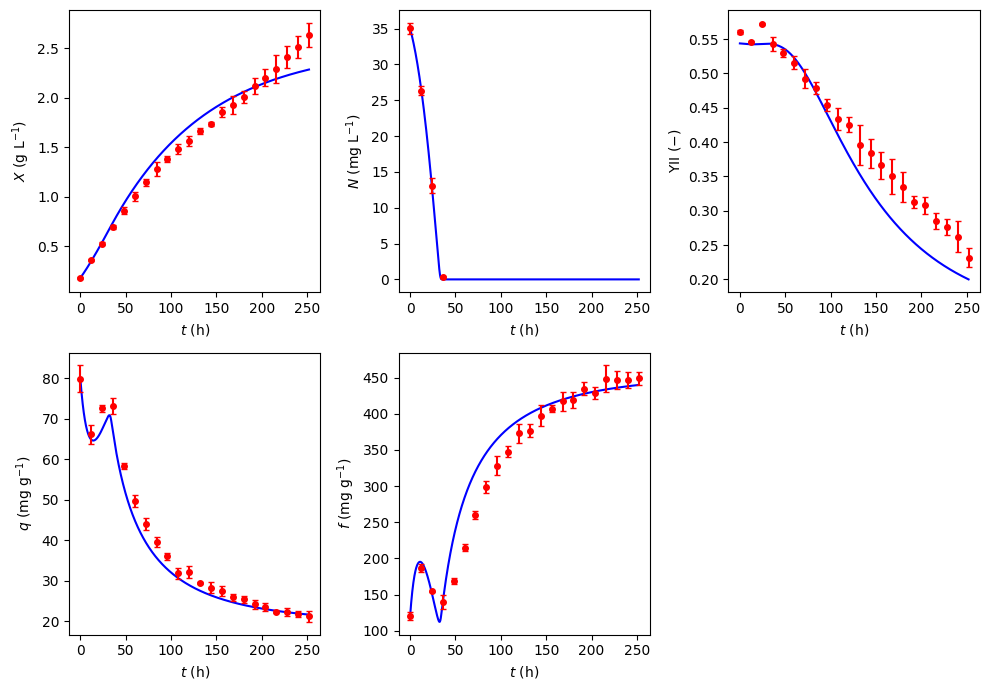

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

axes[0,0].plot( Pred_Exp1[:,0], Pred_Exp1[:,1], color="blue" )
axes[0,0].errorbar(Tmeas_Exp1, Xmeas_Exp1, yerr=Xstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,0].set(xlabel="$t$ (h)")
axes[0,0].set(ylabel="$X$ (g L$^{-1}$)")

axes[0,1].plot( Pred_Exp1[:,0], Pred_Exp1[:,2], color="blue" )
axes[0,1].errorbar(Tmeas_Exp1[:len(Nmeas_Exp1)], Nmeas_Exp1, yerr=Nstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,1].set(xlabel="$t$ (h)")
axes[0,1].set(ylabel="$N$ (mg L$^{-1}$)")

axes[1,0].plot( Pred_Exp1[:,0], Pred_Exp1[:,3], color="blue" )
axes[1,0].errorbar(Tmeas_Exp1, qmeas_Exp1, yerr=qstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,0].set(xlabel="$t$ (h)")
axes[1,0].set(ylabel="$q$ (mg g$^{-1}$)")

axes[1,1].plot( Pred_Exp1[:,0], Pred_Exp1[:,4], color="blue" )
axes[1,1].errorbar(Tmeas_Exp1, fmeas_Exp1, yerr=fstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,1].set(xlabel="$t$ (h)")
axes[1,1].set(ylabel="$f$ (mg g$^{-1}$)")

axes[0,2].plot( Pred_Exp1[:,0], Pred_Exp1[:,5], color="blue" )
axes[0,2].errorbar(Tmeas_Exp1, Ymeas_Exp1, yerr=Ystd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,2].set(xlabel="$t$ (h)")
axes[0,2].set(ylabel="YII ($-$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
fig.tight_layout()

In [8]:
IVP.options.DISPLEVEL = 1 # displays numerical integration results
IVP.options.RESRECORD = 50 # record 50 points along time horizon
IVP.solve_state( [0.36, 0.0, 2.69, 19.6, 0.8, 91.2, 100, 6.69, 7.53, 0.001, 0.0, 196.4, -0.456, 9.90, 0.136],
                 [160, 0.17, 24.6, 79, 112] )
#IVP.solve_state( [0.443, 0.0, 2.850, 19.91, 1.64, 111.8, 250, 6.58, 7.35, 0.0002, 0.0, 260.0, -0.459, 11.05, 0.146],
#                 [160, 0.17, 24.6, 79, 112] )


 @t = 0.000000e+00 :
  x[0] = 1.700000e-01
  x[1] = 2.460000e+01
  x[2] = 7.900000e+01
  x[3] = 1.120000e+02


<Status.Normal: 0>

 @t = 1.200000e+01 :
  x[0] = 3.865604e-01
  x[1] = 1.612454e+01
  x[2] = 5.666763e+01
  x[3] = 2.351418e+02
 @t = 2.400000e+01 :
  x[0] = 6.390286e-01
  x[1] = 1.514553e+00
  x[2] = 5.714214e+01
  x[3] = 2.076209e+02
 @t = 3.600000e+01 :
  x[0] = 8.797696e-01
  x[1] = -5.411899e-10
  x[2] = 4.322725e+01
  x[3] = 2.986981e+02
 @t = 4.800000e+01 :
  x[0] = 1.076653e+00
  x[1] = -4.449054e-13
  x[2] = 3.532238e+01
  x[3] = 3.515158e+02
 @t = 6.000000e+01 :
  x[0] = 1.236934e+00
  x[1] = -1.765481e-15
  x[2] = 3.074528e+01
  x[3] = 3.820855e+02
 @t = 7.200000e+01 :
  x[0] = 1.367393e+00
  x[1] = -4.351228e-17
  x[2] = 2.781195e+01
  x[3] = 4.016702e+02
 @t = 8.400000e+01 :
  x[0] = 1.473593e+00
  x[1] = 8.161904e-18
  x[2] = 2.580757e+01
  x[3] = 4.150489e+02
 @t = 9.600000e+01 :
  x[0] = 1.560061e+00
  x[1] = -1.079231e-18
  x[2] = 2.437715e+01
  x[3] = 4.245946e+02
 @t = 1.080000e+02 :
  x[0] = 1.630477e+00
  x[1] = -4.487327e-19
  x[2] = 2.332436e+01
  x[3] = 4.316189e+02
 @t = 1.20000

In [9]:
# Gather simulation results for Experiment 2
Pred_Exp2 = []
for rec in IVP.results_state:
    [recY] = IVPDAG.eval( [YII], [q, Y0, d, tq], [rec.x[2], -0.456, 9.90, 0.136] )
    Pred_Exp2.append( [rec.t] + rec.x + [recY] )
Pred_Exp2 = np.array( Pred_Exp2 ) # convert list into numpy array

In [10]:
# Experimental dataset 2
Tmeas_Exp2 = np.linspace( 0, 252, 22 )
Xmeas_Exp2 = [ 0.168, 0.412, 0.6234, 0.9114, 1.121, 1.25, 1.376, 1.491, 1.547, 1.616, 1.6466, 1.73, 1.744, 1.752, 1.716, 1.754, 1.746, 1.796, 1.86, 1.868, 1.912, 1.906 ]
Xstd_Exp2  = [ 0.0109544511501033, 0.0131576973669408, 0.078662570514827, 0.0486805916151396, 0.0489131884055824, 0.0651920240520265, 0.0477493455452532, 0.0288097205817759, 0.0399374510954317, 0.0456070170039655, 0.0571646744064899, 0.0346410161513776, 0.0433589667773576, 0.0884307638777367, 0.159154013458662, 0.170967833231868, 0.202188031297601, 0.23880954754783, 0.239269722280111, 0.275535841588712, 0.345427271650633, 0.35711342735887 ]
Nmeas_Exp2 = [ 24.56, 16.44, 1.46 ] #, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
Nstd_Exp2  = [ 0.654217089351845, 0.952890339965727, 0.792464510246358 ] #, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01 ]
qmeas_Exp2 = [ 79.4, 54.7, 57.2, 44.25, 35.2, 30.8, 28.15, 25.45, 26, 24.45, 23.15, 22.45, 22.4, 21.95, 22.5, 22.45, 22.45, 22.35, 22.1, 22.65, 23.05, 23.35 ]
qstd_Exp2  = [ 2.26274169979695, 2.82842712474619, 0.565685424949238, 1.62634559672906, 0.565685424949238, 0.707106781186548, 1.06066017177982, 0.0707106781186532, 1.5556349186104, 0.0707106781186564, 0.0707106781186532, 0.0707106781186532, 0.14142135623731, 0.212132034355963, 1.13137084989848, 0.919238815542511, 2.1920310216783, 2.33345237791561, 2.54558441227157, 2.89913780286485, 3.04055915910216, 3.74766594028872 ]
fmeas_Exp2 = [ 111.541419555231, 265.097777707633, 258.388703449306, 288.601296621711, 335.754543631457, 386.8327041946, 414.59026056901, 439.507223502483, 432.844087468803, 446.664778453333, 449.893233709044, 449.08012514686, 448.115811128386, 451.062200660261, 447.850247629155, 449.383167348635, 437.771893179336, 432.920001998863, 431.965099784869, 423.909181037424, 419.672561698015, 410.466366110378 ]
fstd_Exp2  = [ 7.01025545078043, 0.655484470985941, 5.19140785492464, 13.1526708129503, 3.65650860011034, 5.38552447401581, 3.36976396296463, 11.9645601509965, 1.55513007881774, 0.944056660954174, 7.31483963056877, 5.43718473787734, 7.90628227387481, 0.769130602993408, 10.4490818167955, 20.2549610837514, 19.674661511446, 18.6758933431357, 17.0328029457106, 14.5343388053181, 24.9095089630175, 15.6070595409698 ]
Ymeas_Exp2 = [ 0.555, 0.53425, 0.5575, 0.50325, 0.49725, 0.45525, 0.41425, 0.38025, 0.3295, 0.27975, 0.2525, 0.22675, 0.21275, 0.20575, 0.1995, 0.19325, 0.193, 0.18825, 0.186, 0.17825, 0.17725, 0.175 ]
Ystd_Exp2  = [ 0.00707106781186548, 0.00125830573921179, 0.00519615242270664, 0.0172892066523212, 0.0109048918686371, 0.00704154339142588, 0.0253558014400387, 0.0365365114189446, 0.0478365271872167, 0.0528795801798764, 0.0410649891432269, 0.0310201547384923, 0.0162762608318577, 0.0192591969372211, 0.0122338328690017, 0.0164595463687997, 0.0147648230602334, 0.0185898717944297, 0.0298105126870818, 0.0321597574617719, 0.0398612175763194, 0.0449073119510248 ]

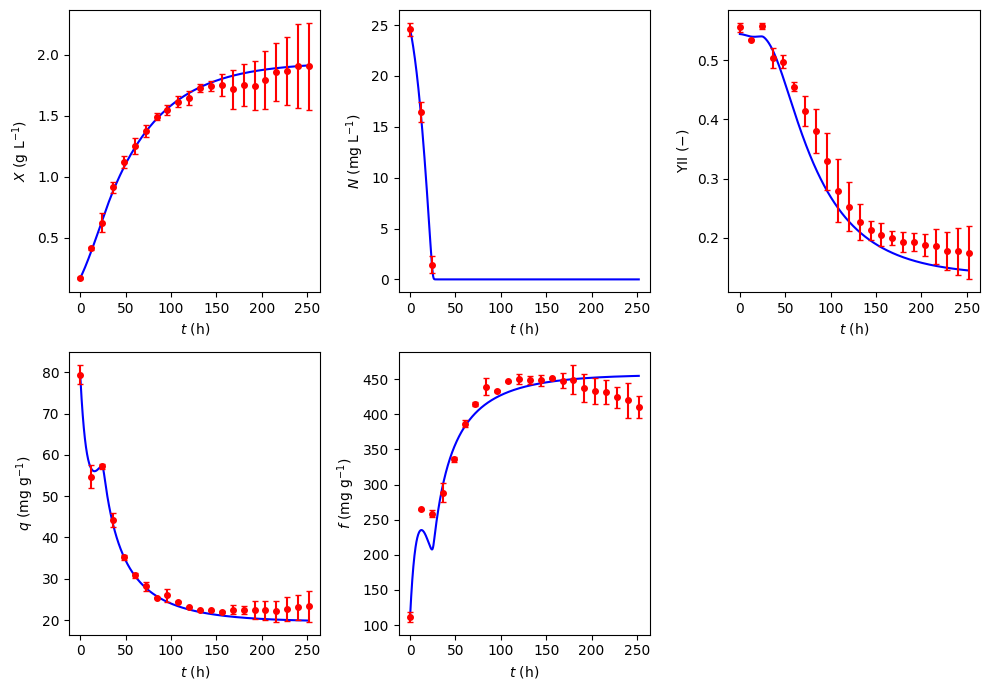

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

axes[0,0].plot( Pred_Exp2[:,0], Pred_Exp2[:,1], color="blue" )
axes[0,0].errorbar(Tmeas_Exp2, Xmeas_Exp2, yerr=Xstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,0].set(xlabel="$t$ (h)")
axes[0,0].set(ylabel="$X$ (g L$^{-1}$)")

axes[0,1].plot( Pred_Exp2[:,0], Pred_Exp2[:,2], color="blue" )
axes[0,1].errorbar(Tmeas_Exp2[:len(Nmeas_Exp2)], Nmeas_Exp2, yerr=Nstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,1].set(xlabel="$t$ (h)")
axes[0,1].set(ylabel="$N$ (mg L$^{-1}$)")

axes[1,0].plot( Pred_Exp2[:,0], Pred_Exp2[:,3], color="blue" )
axes[1,0].errorbar(Tmeas_Exp2, qmeas_Exp2, yerr=qstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,0].set(xlabel="$t$ (h)")
axes[1,0].set(ylabel="$q$ (mg g$^{-1}$)")

axes[1,1].plot( Pred_Exp2[:,0], Pred_Exp2[:,4], color="blue" )
axes[1,1].errorbar(Tmeas_Exp2, fmeas_Exp2, yerr=fstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,1].set(xlabel="$t$ (h)")
axes[1,1].set(ylabel="$f$ (mg g$^{-1}$)")

axes[0,2].plot( Pred_Exp2[:,0], Pred_Exp2[:,5], color="blue" )
axes[0,2].errorbar(Tmeas_Exp2, Ymeas_Exp2, yerr=Ystd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,2].set(xlabel="$t$ (h)")
axes[0,2].set(ylabel="YII ($-$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
fig.tight_layout()

In [12]:
OpIVP = cronos.FFODE()
IVP.options.DISPLEVEL = 0 # turn off display during numerical simulation
IVP.options.RESRECORD = 0 # turn off trajectory record
IVP.options.ATOL, IVP.options.ATOLS, IVP.options.RTOL, IVP.options.RTOLS = 1e-10, 1e-10, 1e-9, 1e-9

# Experiment 1
I0_Exp1 = pymc.FFVar(IVPDAG, "I0_Exp1") # incident light intensity [µmol/m2/s]
X0_Exp1 = pymc.FFVar(IVPDAG, "X0_Exp1")
N0_Exp1 = pymc.FFVar(IVPDAG, "N0_Exp1")
q0_Exp1 = pymc.FFVar(IVPDAG, "q0_Exp1")
f0_Exp1 = pymc.FFVar(IVPDAG, "f0_Exp1")
Y_Exp1 = OpIVP( [mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, d, tq], [I0_Exp1, X0_Exp1, N0_Exp1, q0_Exp1, f0_Exp1], IVP )
IVPDAG.output( Y_Exp1 )

# Experiment 2
I0_Exp2 = pymc.FFVar(IVPDAG, "I0_Exp2") # incident light intensity [µmol/m2/s]
X0_Exp2 = pymc.FFVar(IVPDAG, "X0_Exp2")
N0_Exp2 = pymc.FFVar(IVPDAG, "N0_Exp2")
q0_Exp2 = pymc.FFVar(IVPDAG, "q0_Exp2")
f0_Exp2 = pymc.FFVar(IVPDAG, "f0_Exp2")
Y_Exp2 = OpIVP( [mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, d, tq], [I0_Exp2, X0_Exp2, N0_Exp2, q0_Exp2, f0_Exp2], IVP )
IVPDAG.output( Y_Exp2 )


OPERATIONS IN SUBGRAPH:
  mum	<<  VARIABLE
  kd	<<  VARIABLE
  rhom	<<  VARIABLE
  kq	<<  VARIABLE
  kN	<<  VARIABLE
  kI1	<<  VARIABLE
  kI2	<<  VARIABLE
  gq	<<  VARIABLE
  gN	<<  VARIABLE
  gf	<<  VARIABLE
  e0	<<  VARIABLE
  eX	<<  VARIABLE
  Y0	<<  VARIABLE
  dq	<<  VARIABLE
  tq	<<  VARIABLE
  I0_Exp1	<<  VARIABLE
  X0_Exp1	<<  VARIABLE
  N0_Exp1	<<  VARIABLE
  q0_Exp1	<<  VARIABLE
  f0_Exp1	<<  VARIABLE
  Z276	<<  ODE[0x37a11a20]( mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, dq, tq, I0_Exp1, X0_Exp1, N0_Exp1, q0_Exp1, f0_Exp1 )	[0]
  Z277	<<  ODE[0x37a11a20]( mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, dq, tq, I0_Exp1, X0_Exp1, N0_Exp1, q0_Exp1, f0_Exp1 )	[1]
  Z278	<<  ODE[0x37a11a20]( mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, dq, tq, I0_Exp1, X0_Exp1, N0_Exp1, q0_Exp1, f0_Exp1 )	[2]
  Z279	<<  ODE[0x37a11a20]( mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, dq, tq, I0_Exp1, X0_Exp1, N0_Exp1, q0_Exp1, f0_Exp1 )	[3]
  Z280	<<  OD

In [13]:
IVPDAG.eval( Y_Exp1,
             [mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, d, tq, I0_Exp1, X0_Exp1, N0_Exp1, q0_Exp1, f0_Exp1],
             [0.36, 0.0, 2.69, 19.6, 0.8, 91.2, 100, 6.69, 7.53, 0.001, 0.0, 196.4, -0.456, 9.90, 0.136, 80, 0.18, 35, 80, 120] )
IVPDAG.eval( Y_Exp2,
             [mum, kd, rhom, kq, kN, kI1, kI2, gq, gN, gf, e0, eX, Y0, d, tq, I0_Exp2, X0_Exp2, N0_Exp2, q0_Exp2, f0_Exp2],
             [0.36, 0.0, 2.69, 19.6, 0.8, 91.2, 100, 6.69, 7.53, 0.001, 0.0, 196.4, -0.456, 9.90, 0.136, 160, 0.17, 24.6, 79, 112] )

[0.17,
 24.6,
 79.0,
 112.0,
 0.543786458380948,
 0.386560288369295,
 16.12454557643398,
 56.66762643671541,
 235.1417722855668,
 0.539567117260743,
 0.6390284323742645,
 1.5145390795470028,
 57.142153604639255,
 207.62077619976458,
 0.5398430090192936,
 0.8797694044020371,
 1.8305355979306032e-11,
 43.22723609533566,
 298.698138740954,
 0.5170478280906514,
 1.076654418171223,
 -1.1959886589209087e-14,
 35.3223832621947,
 351.51576776989754,
 0.4689308553680693,
 1.2369361396376766,
 -8.475502543584284e-17,
 30.745322305937737,
 382.08535217542743,
 0.41262196495487696,
 1.3673950512317532,
 1.1455907007577764e-18,
 27.812006979487446,
 401.6699216664629,
 0.36006299127577407,
 1.4735952739974998,
 -6.232766374726324e-21,
 25.80762959295622,
 415.04865580158946,
 0.3155885559478832,
 1.5600640548271547,
 1.0329726167441253e-23,
 24.377204818656402,
 424.5942560117392,
 0.2795108570144507,
 1.6304804483506283,
 -2.36754192635793e-23,
 23.324414024277083,
 431.61852530686906,
 0.25073632

In [14]:
# Instantiate parameter estimation solver
PE = ParEst()

PE.options.DISPLEVEL = 1
PE.options.NLPSLV.DISPLEVEL   = 0;
PE.options.NLPSLV.GRADCHECK   = 0;
PE.options.NLPSLV.MAXTHREAD   = 0;
PE.options.NLPSLV.GRADMETH    = PE.options.NLPSLV.FSYM
PE.options.NLPSLV.FCTPREC     = 1e-6;
PE.options.NLPSLV.GRADLSEARCH = False;

PE.set_dag( IVPDAG )
PE.add_model( Y_Exp1, [I0_Exp1, X0_Exp1, N0_Exp1, q0_Exp1, f0_Exp1], 0 )
PE.add_model( Y_Exp2, [I0_Exp2, X0_Exp2, N0_Exp2, q0_Exp2, f0_Exp2], 1 )
PE.set_parameter( [mum, kd,  rhom, kq,    kN,  kI1,   kI2,   gq,   gN,   gf,     e0,   eX,    Y0,   d,    tq   ],
                   [0.3, 0.0,  1.0,  10.0, 0.2,  50.0,  80.0,  4.0,  1.0, 0.0002,  0.0,  50.0, -2.0,  5.0, 0.05 ],
                   [1.0, 0.5, 10.0, 100.0, 2.0, 200.0, 250.0, 15.0, 10.0, 0.0040, 50.0, 300.0,  2.0, 20.0, 2.0  ] )

In [15]:
# Set experimental data
Exp1 = ParEst.Experiment( [80, 0.18, 35, 80, 120] )

Exp1_out = {}
for k in range(len(Xmeas_Exp1)):
    Exp1_out[len(Y)*k]   = ParEst.Record( [Xmeas_Exp1[k]], 1e-2 ) #Xstd_Exp1[k]**2 )
for k in range(len(Nmeas_Exp1)):
    Exp1_out[len(Y)*k+1] = ParEst.Record( [Nmeas_Exp1[k]], 1e0 ) #Nstd_Exp1[k]**2 )
for k in range(len(qmeas_Exp1)):
    Exp1_out[len(Y)*k+2] = ParEst.Record( [qmeas_Exp1[k]], 4e0 ) #qstd_Exp1[k]**2 )
for k in range(len(fmeas_Exp1)):
    Exp1_out[len(Y)*k+3] = ParEst.Record( [fmeas_Exp1[k]], 1e2 ) #fstd_Exp1[k]**2 )
for k in range(len(Ymeas_Exp1)):
    Exp1_out[len(Y)*k+4] = ParEst.Record( [Ymeas_Exp1[k]], 4e-4 ) #Ystd_Exp1[k]**2 )
#print(Exp1_out)

Exp1.output = Exp1_out
Exp1.index  = 0
#print(Exp1)

Exp2 = ParEst.Experiment( [160, 0.17, 24.6, 79, 112] )

Exp2_out = {}
for k in range(len(Xmeas_Exp2)):
    Exp2_out[len(Y)*k]   = ParEst.Record( [Xmeas_Exp2[k]], 1e-2 ) #Xstd_Exp2[k]**2 )
for k in range(len(Nmeas_Exp2)):
    Exp2_out[len(Y)*k+1] = ParEst.Record( [Nmeas_Exp2[k]], 1e0 ) #Nstd_Exp2[k]**2 )
for k in range(len(qmeas_Exp2)):
    Exp2_out[len(Y)*k+2] = ParEst.Record( [qmeas_Exp2[k]], 4e0 ) #qstd_Exp2[k]**2 )
for k in range(len(fmeas_Exp2)):
    Exp2_out[len(Y)*k+3] = ParEst.Record( [fmeas_Exp2[k]], 1e2 ) #fstd_Exp2[k]**2 )
for k in range(len(Ymeas_Exp2)):
    Exp2_out[len(Y)*k+4] = ParEst.Record( [Ymeas_Exp2[k]], 4e-4 ) #Ystd_Exp2[k]**2 )
#print(Exp2_out)

Exp2.output = Exp2_out
Exp2.index  = 1
#print(Exp2)

Data = [ Exp1, Exp2 ]
PE.set_data( Data );

In [34]:
PE.setup()
PE.mle_solve( [0.36, 0.0, 2.69, 19.6, 0.8, 91.2, 100, 6.69, 7.53, 0.001, 0.0, 196.4, -0.456, 9.90, 0.136] )
#PE.mle_solve( [0.443, 0.0, 2.850, 19.91, 1.64, 111.8, 250, 6.58, 7.35, 0.0002, 0.0, 260.0, -0.459, 11.05, 0.146] )
#PE.mle_solve( 16 )
#print( PE.mle )

# PARAMETER ESTIMATION SOLUTION:
STATUS: 41
X[0]:  LEVEL =  3.302369e-01  MARGINAL = -8.626157e+00
X[1]:  LEVEL =  0.000000e+00  MARGINAL =  4.605757e+04
X[2]:  LEVEL =  2.481654e+00  MARGINAL =  2.036958e+00
X[3]:  LEVEL =  1.958888e+01  MARGINAL =  5.531269e+00
X[4]:  LEVEL =  8.469126e-01  MARGINAL = -5.257611e+00
X[5]:  LEVEL =  9.120317e+01  MARGINAL = -6.146806e-01
X[6]:  LEVEL =  1.000011e+02  MARGINAL = -3.997632e-01
X[7]:  LEVEL =  6.682452e+00  MARGINAL = -1.076218e+01
X[8]:  LEVEL =  7.559867e+00  MARGINAL = -2.653198e+00
X[9]:  LEVEL =  2.000000e-04  MARGINAL =  1.608398e+02
X[10]:  LEVEL =  1.698918e-03  MARGINAL = -3.205500e-01
X[11]:  LEVEL =  1.964016e+02  MARGINAL = -2.272793e-01
X[12]:  LEVEL = -4.590850e-01  MARGINAL =  1.176790e+01
X[13]:  LEVEL =  9.899963e+00  MARGINAL =  4.867634e-01
X[14]:  LEVEL =  1.422678e-01  MARGINAL = -1.279582e+02
F[0]:  LEVEL =  1.608248e+02  MARGINAL = -1.000000e+00


41

In [35]:
IVP.options.RESRECORD = 50 # record 50 points along time horizon
IVP.solve_state( PE.mle.x, [80, 0.18, 35, 80, 120] )

# Gather MLE results for Experiment 2
MLE_Exp1 = []
for rec in IVP.results_state:
    [recY] = IVPDAG.eval( [YII], [q, Y0, d, tq], [rec.x[2], -0.456, 9.90, 0.136] )
    MLE_Exp1.append( [rec.t] + rec.x + [recY] )
MLE_Exp1 = np.array( MLE_Exp1 ) # convert list into numpy array

In [36]:
IVP.options.RESRECORD = 50 # record 50 points along time horizon
IVP.solve_state( PE.mle.x, [160, 0.17, 24.6, 79, 112] )

# Gather MLE results for Experiment 2
MLE_Exp2 = []
for rec in IVP.results_state:
    [recY] = IVPDAG.eval( [YII], [q, Y0, d, tq], [rec.x[2], -0.456, 9.90, 0.136] )
    MLE_Exp2.append( [rec.t] + rec.x + [recY] )
MLE_Exp2 = np.array( MLE_Exp2 ) # convert list into numpy array

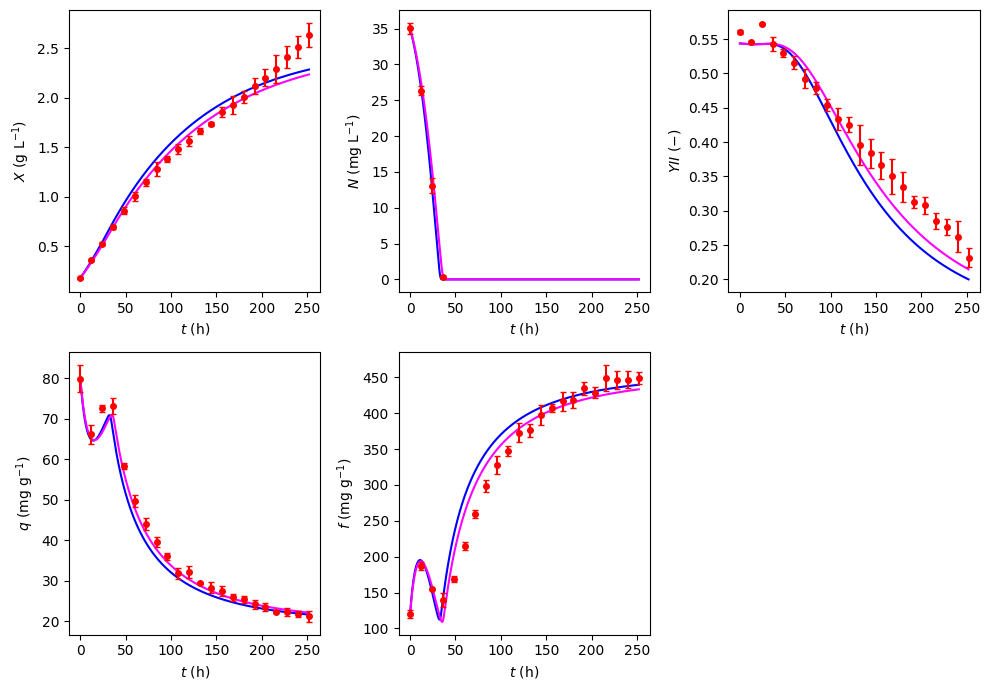

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

axes[0,0].plot( Pred_Exp1[:,0], Pred_Exp1[:,1], color="blue" )
axes[0,0].plot( MLE_Exp1[:,0], MLE_Exp1[:,1], color="magenta" )
axes[0,0].errorbar(Tmeas_Exp1, Xmeas_Exp1, yerr=Xstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,0].set(xlabel="$t$ (h)")
axes[0,0].set(ylabel="$X$ (g L$^{-1}$)")

axes[0,1].plot( Pred_Exp1[:,0], Pred_Exp1[:,2], color="blue" )
axes[0,1].plot( MLE_Exp1[:,0], MLE_Exp1[:,2], color="magenta" )
axes[0,1].errorbar(Tmeas_Exp1[:len(Nmeas_Exp1)], Nmeas_Exp1, yerr=Nstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,1].set(xlabel="$t$ (h)")
axes[0,1].set(ylabel="$N$ (mg L$^{-1}$)")

axes[1,0].plot( Pred_Exp1[:,0], Pred_Exp1[:,3], color="blue" )
axes[1,0].plot( MLE_Exp1[:,0], MLE_Exp1[:,3], color="magenta" )
axes[1,0].errorbar(Tmeas_Exp1, qmeas_Exp1, yerr=qstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,0].set(xlabel="$t$ (h)")
axes[1,0].set(ylabel="$q$ (mg g$^{-1}$)")

axes[1,1].plot( Pred_Exp1[:,0], Pred_Exp1[:,4], color="blue" )
axes[1,1].plot( MLE_Exp1[:,0], MLE_Exp1[:,4], color="magenta" )
axes[1,1].errorbar(Tmeas_Exp1, fmeas_Exp1, yerr=fstd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,1].set(xlabel="$t$ (h)")
axes[1,1].set(ylabel="$f$ (mg g$^{-1}$)")

axes[0,2].plot( Pred_Exp1[:,0], Pred_Exp1[:,5], color="blue" )
axes[0,2].plot( MLE_Exp1[:,0], MLE_Exp1[:,5], color="magenta" )
axes[0,2].errorbar(Tmeas_Exp1, Ymeas_Exp1, yerr=Ystd_Exp1, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,2].set(xlabel="$t$ (h)")
axes[0,2].set(ylabel="$YII$ ($-$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
fig.tight_layout()

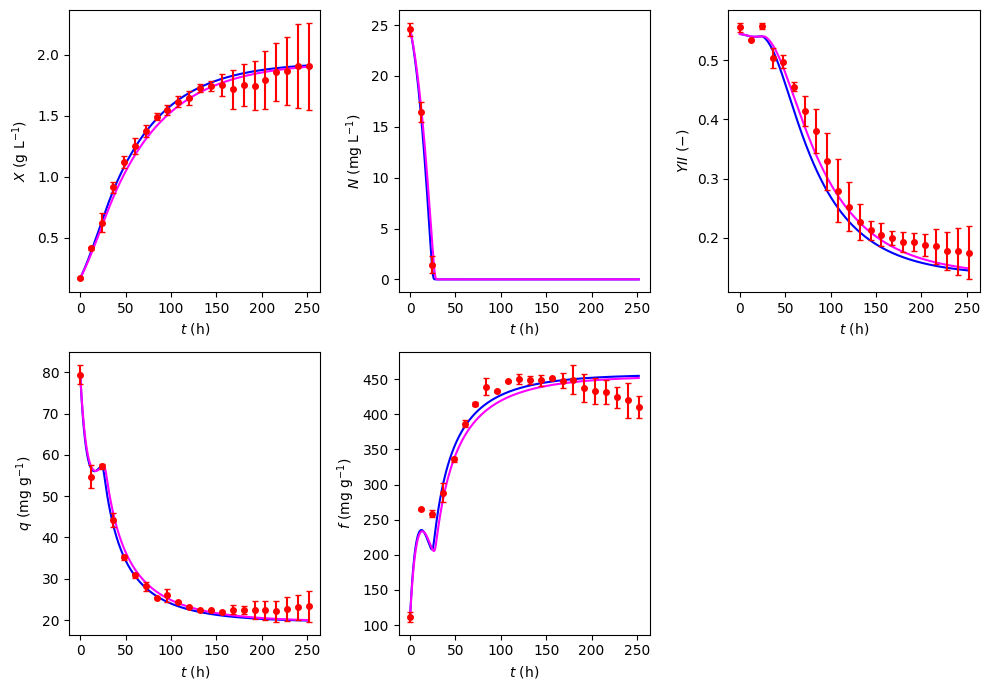

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

axes[0,0].plot( Pred_Exp2[:,0], Pred_Exp2[:,1], color="blue" )
axes[0,0].plot( MLE_Exp2[:,0], MLE_Exp2[:,1], color="magenta" )
axes[0,0].errorbar(Tmeas_Exp2, Xmeas_Exp2, yerr=Xstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,0].set(xlabel="$t$ (h)")
axes[0,0].set(ylabel="$X$ (g L$^{-1}$)")

axes[0,1].plot( Pred_Exp2[:,0], Pred_Exp2[:,2], color="blue" )
axes[0,1].plot( MLE_Exp2[:,0], MLE_Exp2[:,2], color="magenta" )
axes[0,1].errorbar(Tmeas_Exp2[:len(Nmeas_Exp2)], Nmeas_Exp2, yerr=Nstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,1].set(xlabel="$t$ (h)")
axes[0,1].set(ylabel="$N$ (mg L$^{-1}$)")

axes[1,0].plot( Pred_Exp2[:,0], Pred_Exp2[:,3], color="blue" )
axes[1,0].plot( MLE_Exp2[:,0], MLE_Exp2[:,3], color="magenta" )
axes[1,0].errorbar(Tmeas_Exp2, qmeas_Exp2, yerr=qstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,0].set(xlabel="$t$ (h)")
axes[1,0].set(ylabel="$q$ (mg g$^{-1}$)")

axes[1,1].plot( Pred_Exp2[:,0], Pred_Exp2[:,4], color="blue" )
axes[1,1].plot( MLE_Exp2[:,0], MLE_Exp2[:,4], color="magenta" )
axes[1,1].errorbar(Tmeas_Exp2, fmeas_Exp2, yerr=fstd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[1,1].set(xlabel="$t$ (h)")
axes[1,1].set(ylabel="$f$ (mg g$^{-1}$)")

axes[0,2].plot( Pred_Exp2[:,0], Pred_Exp2[:,5], color="blue" )
axes[0,2].plot( MLE_Exp2[:,0], MLE_Exp2[:,5], color="magenta" )
axes[0,2].errorbar(Tmeas_Exp2, Ymeas_Exp2, yerr=Ystd_Exp2, marker='o', ms=4, c='r', ls='', capsize=2, label="data")
axes[0,2].set(xlabel="$t$ (h)")
axes[0,2].set(ylabel="$YII$ ($-$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
fig.tight_layout()

In [39]:
chi2 = PE.chi2_test( 0.95 )
#print( chi2 )


# CHI-SQUARED TEST: 3.216e+02 > 1.992e+02 CRITICAL CHI_SQUARED VALUE (95%, 168 DOF)
# CHI-SQUARED TEST PASSED WITH >100.0% CONFIDENCE LEVEL


In [40]:
print( PE.mle )


STATUS: 41
X[0]:  LEVEL =  3.302369e-01  MARGINAL = -8.626157e+00
X[1]:  LEVEL =  0.000000e+00  MARGINAL =  4.605757e+04
X[2]:  LEVEL =  2.481654e+00  MARGINAL =  2.036958e+00
X[3]:  LEVEL =  1.958888e+01  MARGINAL =  5.531269e+00
X[4]:  LEVEL =  8.469126e-01  MARGINAL = -5.257611e+00
X[5]:  LEVEL =  9.120317e+01  MARGINAL = -6.146806e-01
X[6]:  LEVEL =  1.000011e+02  MARGINAL = -3.997632e-01
X[7]:  LEVEL =  6.682452e+00  MARGINAL = -1.076218e+01
X[8]:  LEVEL =  7.559867e+00  MARGINAL = -2.653198e+00
X[9]:  LEVEL =  2.000000e-04  MARGINAL =  1.608398e+02
X[10]:  LEVEL =  1.698918e-03  MARGINAL = -3.205500e-01
X[11]:  LEVEL =  1.964016e+02  MARGINAL = -2.272793e-01
X[12]:  LEVEL = -4.590850e-01  MARGINAL =  1.176790e+01
X[13]:  LEVEL =  9.899963e+00  MARGINAL =  4.867634e-01
X[14]:  LEVEL =  1.422678e-01  MARGINAL = -1.279582e+02
F[0]:  LEVEL =  1.608248e+02  MARGINAL = -1.000000e+00


In [41]:
cov1  = PE.cov_linearized()
#print( cov1)

cint95 = PE.conf_interval( cov1, 0.95, "T" )
#print( cint95 )


# PARAMETER COVARIANCE MATRIX (VIA LINEARIZATION):
1.03138e-04 -8.37750e-23 1.41680e-04 1.06446e-03 3.75005e-04 2.81118e-02 2.08802e-02 3.12235e-04 5.62340e-04 1.64702e-20 -1.44427e-03 1.53957e-02 -9.17641e-07 8.05524e-03 3.36372e-05
-8.37750e-23 2.69771e-38 5.10900e-22 -2.04150e-20 6.87795e-22 8.05565e-20 5.53799e-20 -9.61445e-21 -1.60736e-20 -1.12671e-36 -1.60252e-20 1.82207e-19 8.60041e-23 -2.24002e-19 -9.59821e-22
1.41680e-04 5.10900e-22 1.01552e-02 -6.39950e-03 2.74739e-02 -8.61095e-02 -5.57712e-02 -9.28159e-04 -1.96624e-03 -5.51480e-19 -2.97454e-01 7.18630e-01 3.69478e-05 -3.16574e-02 -1.55278e-04
1.06446e-03 -2.04150e-20 -6.39950e-03 1.34060e-01 -3.06916e-03 2.86282e-01 2.10700e-01 2.21279e-02 3.57242e-02 2.83020e-18 7.59217e-01 -2.21010e+00 -1.00448e-04 7.35701e-01 2.91701e-03
3.75005e-04 6.87795e-22 2.74739e-02 -3.06916e-03 1.48327e-01 -6.36887e-02 -3.00473e-02 9.79814e-03 1.65260e-02 -1.57369e-18 -4.37683e-01 9.96372e-01 7.65749e-05 -2.33229e-02 -1.47363e-04
2.81118e-02 8.05